# Ground-State Energy of H₂ with VQE (Qubit Hamiltonian Input)

In this notebook, I reproduce the VQE workflow for estimating the ground-state energy of a small molecular system using a pre-defined qubit Hamiltonian. I use H₂ as the example because its mapped Hamiltonian is compact enough to be written explicitly as a sum of Pauli strings.

This notebook precedes the "Molecular-Geometry" notebook: here the nuclear geometry is fixed, so the Hamiltonian is fixed, and VQE is used only to estimate the ground-state energy.


## Step 1 — Mapping classical inputs to a quantum problem

The molecular Hamiltonian used in this notebook is obtained by mapping the electronic structure problem—defined by the atomic species, fixed geometry, basis set, and a fermion-to-qubit transformation—into a qubit operator. This mapping step is carried out in the preceding notebook, **Hamiltonian**, where the fermionic Hamiltonian is constructed and transformed into a sum of Pauli operators.

Here, I take that resulting **qubit Hamiltonian**, expressed as a `SparsePauliOp`, as the starting point for the VQE calculation. The Hamiltonian corresponds to the H₂ molecule and acts on 4 qubits. The nuclear repulsion energy is included separately as a classical constant and is added back to the electronic energy when reporting the total molecular energy.


In [1]:
# General imports
import numpy as np
from qiskit.quantum_info import SparsePauliOp
 
# Hamiltonian obtained from notebook titled "Hamiltonian"
 
H = SparsePauliOp(
    [
        "IIII",
        "IIIZ",
        "IZII",
        "IIZI",
        "ZIII",
        "IZIZ",
        "IIZZ",
        "ZIIZ",
        "IZZI",
        "ZZII",
        "ZIZI",
        "YYYY",
        "XXYY",
        "YYXX",
        "XXXX",
    ],
    coeffs=[
        -0.09820182 + 0.0j,
        -0.1740751 + 0.0j,
        -0.1740751 + 0.0j,
        0.2242933 + 0.0j,
        0.2242933 + 0.0j,
        0.16891402 + 0.0j,
        0.1210099 + 0.0j,
        0.16631441 + 0.0j,
        0.16631441 + 0.0j,
        0.1210099 + 0.0j,
        0.17504456 + 0.0j,
        0.04530451 + 0.0j,
        0.04530451 + 0.0j,
        0.04530451 + 0.0j,
        0.04530451 + 0.0j,
    ],
)
 
nuclear_repulsion = 0.7199689944489797

I begin by choosing the `EfficientSU2` ansatz and the COBYLA optimizer as a simple, hardware-efficient starting point for the VQE calculation.


5


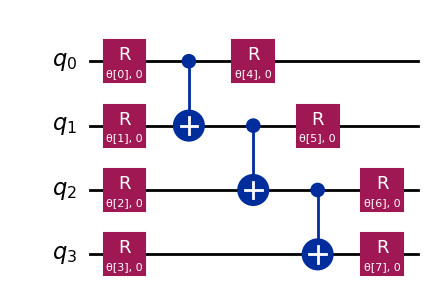

In [5]:
# Pre-defined ansatz circuit
from qiskit.circuit.library import efficient_su2
 
# SciPy minimizer routine
from scipy.optimize import minimize
 
# Plotting functions
 
# Random initial state and efficient_su2 ansatz
ansatz = efficient_su2(H.num_qubits, su2_gates=["rx"], entanglement="linear", reps=1)
x0 = 2 * np.pi * np.random.random(ansatz.num_parameters)
print(ansatz.decompose().depth())
ansatz.decompose().draw("mpl")

Next, I define the cost function used by the VQE optimizer. While the Hamiltonian itself is an operator, the optimization requires a numerical objective. This cost function evaluates the energy corresponding to a parameterized ansatz state by computing the Hamiltonian’s expectation value using Qiskit’s Estimator primitive. The same function is used for both simulator and hardware execution; only the estimator backend differs.


In [6]:
def cost_func(params, ansatz, H, estimator):
    pub = (ansatz, [H], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]
    return energy
 
 
# def cost_func_sim(params, ansatz, H, estimator):
#    energy = estimator.run(ansatz, H, parameter_values=params).result().values[0]
#    return energy

## Step 2 — Optimizing the problem for quantum execution

To run the VQE workflow efficiently, the circuit must be optimized for a specific target device. Rather than selecting the least-busy backend dynamically, I explicitly target a fixed IBM Quantum processor so that all compilation and optimization steps are consistent across runs.

In this notebook, I use the **IBM Quantum Nighthawk R1 processor**, introduced at IBM Quantum Developer Conference (QDC). Fixing the backend in this way allows the transpilation and scheduling strategy to be tailored to a known hardware architecture, independent of the VQE algorithm itself.


In [18]:
service = QiskitRuntimeService(channel="ibm_cloud", instance="--", token="--") #credentials deleted
backend = service.backend("ibm_miami")
print(backend)

<IBMBackend('ibm_miami')>


### Circuit optimization and noise mitigation

I optimize the circuit for the target hardware using Qiskit’s transpiler with the highest preset optimization level to reduce gate count and circuit depth. Since multi-qubit gates are noisy and qubits decohere over time, shorter circuits generally yield better results.

I also apply dynamical decoupling during scheduling to mitigate decoherence on idle qubits. This optimization is hardware-specific but independent of the Hamiltonian and is reused across all VQE runs.


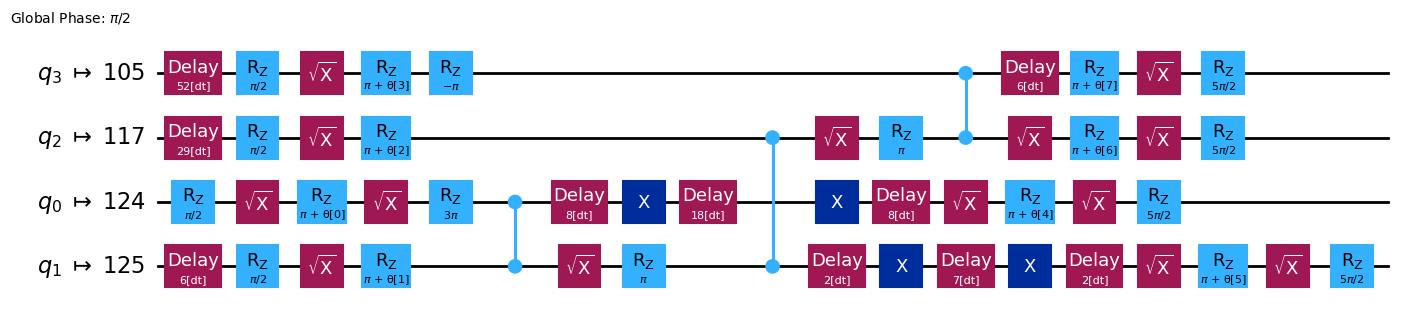

In [11]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.passes import (
    ALAPScheduleAnalysis,
    PadDynamicalDecoupling,
    ConstrainedReschedule,
)
from qiskit.circuit.library import XGate
 
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
pm.scheduling = PassManager(
    [
        ALAPScheduleAnalysis(target=target),
        ConstrainedReschedule(
            acquire_alignment=target.acquire_alignment,
            pulse_alignment=target.pulse_alignment,
            target=target,
        ),
        PadDynamicalDecoupling(
            target=target,
            dd_sequence=[XGate(), XGate()],
            pulse_alignment=target.pulse_alignment,
        ),
    ]
)
 
 
# Use the pass manager and draw the resulting circuit
ansatz_isa = pm.run(ansatz)
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

Because transpilation maps logical qubits to specific physical qubits on the device, the Hamiltonian must be updated to reflect the same qubit layout. Applying the circuit layout to the Hamiltonian ensures that expectation values are measured on the correct physical qubits.


In [12]:
hamiltonian_isa = H.apply_layout(ansatz_isa.layout)
hamiltonian_isa

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIII

# Step-3 Execute using Qiskit Primitives

#### Using a local simulator with a hardware-derived noise model

Before running on real quantum hardware, I execute the VQE workflow on a local simulator. The simulator is configured using a noise model extracted from the target backend, allowing for preliminary debugging and approximate error estimation. While such simulations cannot fully reproduce large-scale quantum hardware behavior, they are useful for validating the workflow and setting realistic expectations prior to hardware execution.


In [13]:
# We will start by using a local simulator
from qiskit_aer import AerSimulator
 
# Import an estimator, this time from qiskit (we will import from Runtime for real hardware)
from qiskit.primitives import BackendEstimatorV2
 
# generate a simulator that mimics the real quantum system
backend_sim = AerSimulator.from_backend(backend)
estimator = BackendEstimatorV2(backend=backend_sim)

I now execute the VQE workflow by minimizing the cost function using the selected Hamiltonian, ansatz, classical optimizer, and a `BackendEstimator` configured for the chosen hardware. For this step, I use a relatively small number of optimizer iterations, as the simulator is primarily used for debugging and workflow validation. In practice, accurate VQE convergence typically requires substantially more optimization steps.


In [14]:
res = minimize(
    cost_func,
    x0,
    args=(ansatz_isa, hamiltonian_isa, estimator),
    method="cobyla",
    options={"maxiter": 10, "disp": True},
)
 
print(getattr(res, "fun") - nuclear_repulsion)
print(res)

Return from COBYLA because the objective function has been evaluated MAXFUN times.
Number of function values = 10   Least value of F = -0.21590608671874995
The corresponding X is:
[5.04182812 4.32522511 1.35056522 2.19310305 4.91273946 2.03234269
 6.54109036 1.65344051]

-0.9358750811677297
 message: Return from COBYLA because the objective function has been evaluated MAXFUN times.
 success: False
  status: 3
     fun: -0.21590608671874995
       x: [ 5.042e+00  4.325e+00  1.351e+00  2.193e+00  4.913e+00
            2.032e+00  6.541e+00  1.653e+00]
    nfev: 10
   maxcv: 0.0


### Interpreting the VQE output

The optimizer returns several diagnostic quantities that help assess the quality of the VQE run. The value reported as `fun` corresponds to the **minimum value of the cost function encountered during optimization**, not necessarily the final evaluation. This value represents the **total energy expectation value**, including the nuclear repulsion contribution. Subtracting the nuclear repulsion yields the estimated electronic energy.

In this run, COBYLA terminated because the maximum number of function evaluations (`nfev = 10`) was reached. As a result, the convergence criteria were not satisfied and the optimizer reports `success = False`. This behavior is expected, since the number of iterations was intentionally kept small and the calculation was performed on a noise-modelled local simulator for debugging and workflow validation rather than full convergence.

The parameter vector `x` contains the variational parameters corresponding to the minimum energy found during the optimization. These values define the rotation angles in the parameterized ansatz circuit that produced the lowest measured energy.

Although this calculation does not yield a fully converged ground-state energy, it demonstrates the complete VQE workflow: Hamiltonian preparation, circuit transpilation and layout application, estimator-based energy evaluation, and classical optimization. Increasing the optimization budget and/or running on real hardware with error mitigation would be required to obtain a quantitatively accurate ground-state energy.
